<h1><center>Primal Dual Hybrid Gradient Algorithm: Part II (Tomography) </center></h1>

In this demo, we learn how to use the Primal Dual hubrid aglorithm introduced in [ChampollePock, ] for Tomography reconstruction. 

## Learning objectives

1. Define AcquisitionGeometry, ImageGeometry and Projection operator for our tomography problem.
1. Run standard iterative reconstruction techniques such as FBP, SIRT and CGLS.
1. Setup PDHG for Tomography reconstuction using a Total Variation regulariser.
1. Use PDHG with the __BlockFramework__ and with the __CCPi-Regularisation Toolkit__.

## Prerequisites

- AcquisitionData, AcquisitionGeometry.
- AstraProjectorSimple, AstraProjectorSimple3D.
- BlockOperator, BlockFunction.
- FBP, SIRT, CGLS, Tikhonov

<h1><center> Example: Tomography Reconstuction</center></h1>   
<img src="images/tomo_all.jpeg"  width="800"/>


### Reminder

So far, we have used

- __Filtered BackProjection (FBP)__, 
- __Conjugate Gradient Least Squares (CGLS)__.

In the case of CGLS, we presented also a __regularised__ version, namely the __Tikhonov regularisation__

<a id='Tikhonov'></a>
$$ \underset{u}{\operatorname{argmin}} \|\mathcal{A} u - g\|^{2}_{2} + \alpha^{2}\|L u\|^{2}_{2}, $$

where, 

- $\mathcal{A}$ is a projection operator from an ImageGeometry X to an AcquisitionGeometry Y,
- $g$ is acquisition data, 
- $L$ is a linear operator, i.e., $L=\nabla$, $L = \mathbb{I}$,
- $\alpha$ is a regularising parameter that measures a trade-off between the fidelity and the regulariser term.

Note that due to the $\|\cdot\|_{2}^{2}$ terms, we can express the above problem into a __Block Structure__ of CGLS, i.e.,

$$ 
\begin{align}
\underset{u}{\operatorname{argmin}} &\|\mathcal{A} u - g\|^{2}_{2} + \alpha^{2}\|L u\|^{2}_{2}\\
\underset{u}{\operatorname{argmin}} & \sum (\mathcal{A} u - g)^{2} + \alpha^{2}\sum (L u)^{2}\\
\underset{u}{\operatorname{argmin}} &\sum (\mathcal{A} u - g)^{2} + \alpha^{2}(L u)^{2}\\
\underset{u}{\operatorname{argmin}} &\sum 
(\begin{bmatrix}
A \\
\alpha L 
\end{bmatrix} u 
- \begin{bmatrix}
g \\
0
\end{bmatrix})^{2} = \underset{u}{\operatorname{argmin}} \|\tilde{\mathcal{A}} u - \tilde{g}\|^{2}
\end{align}
$$


## Non-smooth objective: (CGLS with PDHG)

However, this is not always the case and in general both of the data-fitting terms and regularisers are not differentiable. Consider for example an $L^{1}$ norm for the fidelity, i.e., $\|\mathcal{A} u - g\|^{1}$ or an $L^{1}$ norm of the regulariser i.e., $\|u\|_{1}$.

Using the __Primal-Dual hybrid gradient algorithm__, we can solve minimisation problems that are not differentiable. We are interested in problems with the following form 

$$\underset{u}{\operatorname{argmin}} \mathcal{F}(K u) + \mathcal{G}(u),$$

where we  __only__ assume that:

1. $\mathcal{F}$, $\mathcal{G}$ are __convex__ functionals
    
    - $\mathcal{F}: Y \rightarrow \mathbb{R}$ 
    
    - $\mathcal{G}: X \rightarrow \mathbb{R}$
    
    
2. $K$ is a continuous linear operator acting from a space X to another space Y :

$$K : X \rightarrow Y \quad \mbox{ with operator norm defined as }\quad \| K \| = \max\{ \|K x\|_{Y} : \|x\|_{X}\leq 1 \}.$$    

Now, the least-squares problem of CLGS can be expressed in this form $$\min_{u} \mathcal{F}(K u) + \mathcal{G}(u)$$ quite easily. Let,

- $K = \mathcal{A}$,  $K: X \rightarrow Y$,
- $F: Y \rightarrow \mathbb{R}$, with $F(z) := \frac{1}{2}\| z - g \|^{2},$
- $G: X \rightarrow \mathbb{R}$, with $G(z) := 0$.

Then, $$\underset{u}{\operatorname{argmin}} \mathcal{F}(K u) + \mathcal{G}(u) = \underset{u}{\operatorname{argmin}} \frac{1}{2}\| \mathcal{A}u - g \|^{2}.$$


## How to setup and run PDHG

Basically, in order to setup and run PDHG, we need to define:

- The operator K.
- The function $\mathcal{F}$ and $\mathcal{G}$.
- Step-sizes $\sigma$ and $\tau$ such that $\sigma\tau\|K\|^{2}<1$, see [Appendix](#Appendix).

The setup of PDHG is:

` pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, max_iterations = maxiter)`

` pdhg.run()`

In [1]:
# Imports
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from ccpi.framework import ImageData, ImageGeometry, AcquisitionGeometry, AcquisitionData, BlockDataContainer

from ccpi.optimisation.functions import L2NormSquared, ZeroFunction, BlockFunction, MixedL21Norm, IndicatorBox, FunctionOperatorComposition
from ccpi.optimisation.operators import Gradient, BlockOperator
from ccpi.optimisation.algorithms import PDHG, SIRT, CGLS

from ccpi.astra.operators import AstraProjectorSimple, AstraProjector3DSimple
from ccpi.astra.processors import FBP

from ccpi.processors import Resizer, CenterOfRotationFinder

from ccpi.io import NEXUSDataReader

import tomophantom
from tomophantom import TomoP2D, TomoP3D
import os, sys

import matplotlib.pyplot as plt

import numpy as np

from utilities import islicer
from utilities.show_utilities import show

## Tomophantom Library

First, we load a phantom, from the [Tomophantom](https://github.com/dkazanc/TomoPhantom) package. We can
choose different 2D,3D & 4D phantoms from this [library](https://github.com/dkazanc/TomoPhantom/tree/master/PhantomLibrary/models). For the well-known Shepp-Logan phantom, use _model = 1_ in the code below.

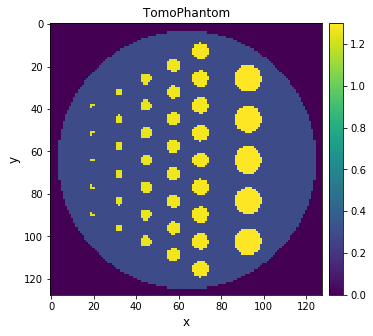

In [2]:
model = 4 # select a model number from the library
N = 128 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom = TomoP2D.Model(model, N, path_library2D) 

# Define image geometry.
ig = ImageGeometry(voxel_num_x = N, voxel_num_y = N)
im_data = ig.allocate()
im_data.fill(phantom)

show(im_data, title = 'TomoPhantom')

## AcquisitionGeometry/ImageGeometry

Next step is to create an acquisition data, using the tomophantom. We need to define an acquisition space, where this data belongs to. This acquisition space, will help us to define our (linear) operator $\mathcal{A}$ as 

$$\mathcal{A}: \mathrm{ImageGeometry} \rightarrow \mathrm{AcquisitionGeometry}$$

For this task, we use a detector with _ 2D parallel geometry_, described in the figures below. 
- ImageData is the tomophantom of size (N,N) that is an element of ImageGeometry. 
- For the acquisition geometry, we need to specify
    1. The type of geometry
    1. The number of detectors
    1. The number of angles. Note we need them in radians.

<img src="images/parallel_data.png" width="350" align="left" style="margin-right: 75px"/>
<img src="images/parallel_geometry.png" width="470"  align="left"/>   

The projection operator $\mathcal{A}$ has two methods __direct__ and __adjoint__ that compute the __forward__ and __backward__ projection. Therfore, if we want to project and obtain an AcquisitionData we write

- _sino = A.direct(tomophantom)_ 

and to backproject 

- _recon = A.adjoint(sino)_.

Below, we define our AcquisitionGeometry and AcquisitionData. 

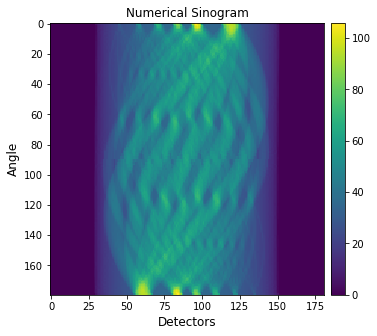

In [3]:
# Create AcquisitionGeometry and AcquisitionData 
detectors = int(np.sqrt(2)*N)
angles = np.linspace(0, np.pi, 180, dtype='float32')
ag = AcquisitionGeometry('parallel','2D', angles, detectors)

# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = AstraProjectorSimple(ig, ag, device='cpu')

# Create an acqusition data (numerically)
sino_num = A.direct(im_data)

# Show numerical sinogram
show(sino_num, title = 'Numerical Sinogram', labels = ['Detectors','Angle'])

# Exercise 1: CGLS vs PDHG

In this exercise, we will compare CGLS with PDHG for the minimisation problem

$$\underset{u}{\operatorname{argmin}} \|\mathcal{A} u - g\|^{2}_{2}$$

Recall, that the setup for CGLS is:

` cgls = CGLS(x_init = x_init, operator = A, data = sino_num, max_iteration = 10)`

` cgls.run(verbose=False)`

In [4]:
# Setup and run CGLS reconstruction 

### START CODE HERE (3 lines) ### 
    
    # x_init = ig.allocate()
    # cgls = ...
    # cgls.run()
    # cgls_recon = cgls.get_output()
    
### END CODE HERE ###

# Setup and run PDHG reconstruction 

### START CODE HERE (6 lines) ### 
    
    # K = ...
    # F = ...
    # G = ...
    
    # sigma = 1
    # tau = 1/(sigma * tau ||A||^{2})
    
    # pdhg = ...
    # pdhg.run()
    # pdhg_recon = pdhg.get_output()
    
### END CODE HERE ###

CGLS setting up
CGLS configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          4.29371e+07
       20        100         0.047          2.07803e+06
       40        100         0.046          2.84037e+02
       60        100         0.047          4.57283e+01
       80        100         0.046          1.48112e+01
      100        100         0.048          5.77831e+00
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        200         0.000    4.29371e+07  -0.00000e+00    4.29371e+07
       50        200         0.050    6.81193e+06  -5.42429e+07    6.10548e+07
      100        200         0.048    8.03614e+03  -4.81433e+04    5.61794e+04
      150        200         0.049    1.81895e+03  -2.31767e+04    2.49956e+04
      200     

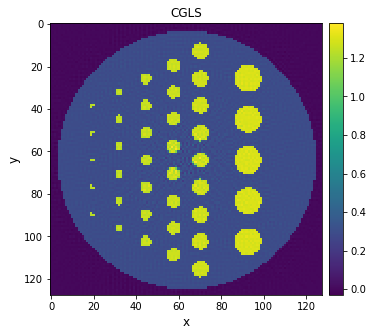

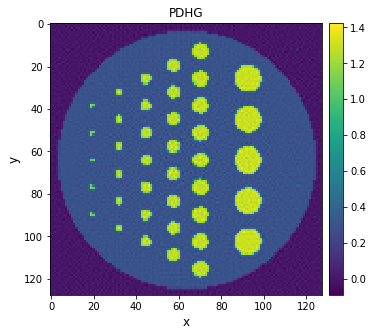

In [21]:
# Setup and run CGLS reconstruction 

x_init = ig.allocate()
cgls = CGLS(x_init = x_init, operator = A, data = sino_num, max_iteration = 100, update_objective_interval = 20)
cgls.run(verbose = True)
cgls_recon = cgls.get_output()

# Setup and run PDHG reconstruction

K = A
F = L2NormSquared(sino_num)
G = ZeroFunction()

normK = K.norm()
sigma = 1
tau = 1/(sigma*normK**2)
pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, max_iteration = 200, update_objective_interval = 50)
pdhg.run(verbose = True)
pdhg_recon = pdhg.get_output()

show(cgls_recon, title = 'CGLS')
show(pdhg_recon, title = 'PDHG')

# Total Variation Regularisation

In this section, we use PDHG algorithm with a non-smooth regularisation, namely the $L^{1}$ norm of the Gradient which is called  __Total variation regularisation__, see [ROF](#ROF). If in [Tikhonov regularisation](#Tikhonov), we set $L=\nabla$, then we have a smooth regulariser, i.e., the squared $L^{2}$ norm of the Gradient. However, it is not possible to apply CGLS with a non-smooth regulariser.

<a id='TomoTV'></a>
The problem, we would like to solve is:
$$ \underset{u}{\operatorname{argmin}} \frac{1}{2} \| \mathcal{A} u - g\|^{2} + \alpha\,\mathrm{TV}(u) +  \mathbb{I}_{\{u>0\}}(u) $$


where,
1. The total variation is $$\mathrm{TV}(u) = \|\nabla u \|_{2,1} = \sum \sqrt{ (\partial_{y}u)^{2} + (\partial_{x}u)^{2} }$$
1. g is the Acqusisition data obtained from the detector.
1. $\mathcal{A}$ is the projection operator ( _Radon transform_ ) that maps from an image-space to an acquisition space, i.e., $\mathcal{A} : X \rightarrow Y, $ where X is an __ImageGeometry__ and Y is an __AcquisitionGeometry__.
1. $\mathbb{I}_{\{u>0\}}(u) : = 
\begin{cases}
0, & \mbox{ if } u>0\\
\infty , & \mbox{ otherwise}
\quad
\end{cases}
$, $\quad$ a positivity constraint for the minimiser $u$.

## BlockFunction

In order to setup the above problem we need the BlockFramework and in particular the concepts of __BlockOperator__, __BlockDataContainer__ and __BlockFunction__. In the previous demos, we have already discussed BlockOperator and BlockDataContainer. BlockFucntion is similar to a BlockOperator and BlockDataContainer but instead of operators or containers we _append_ functions as below:

$$ F = [f_{1}, f_{2}]$$

For example, let 

$$\begin{align}
f_{1}: Y \rightarrow \mathbb{R}, \quad f_{1}(z_{1}) = \alpha\,\|z_{1}\|_{2,1}, \mbox{ ( the TV term ) }\\
f_{2}: X \rightarrow \mathbb{R}, \quad f_{2}(z_{2}) = \frac{1}{2}\|z_{2} - g\|_{2}^{2}, \mbox{ ( the data-fitting term ) }
\end{align}$$

and consider $z = (z_{1}, z_{2})\in Y\times X$, then 
<a id='BlockFunction'></a>
$$F(z) : = F((x_{1},x_{2}) = f_{1}(x_{1}) + f_{2}(x_{2})$$

In a sense, $F(z)$ is a __separable sum__ of decoupled functions. __So, why do we need to write in this form__? It turns out, that the __proximal operator of a BlockFunction__ can be separated, i.e., 

$$\mathrm{prox}_{\tau F}(z) = 
\begin{bmatrix}
\mathrm{prox}_{\tau f_1}(z_1)\\
\mathrm{prox}_{\tau f_2}(z_2)
\end{bmatrix} = 
\begin{bmatrix}
\underset{w_{1}\in Y}{\operatorname{argmin}} \tau f_{1}(w_{1}) + \frac{1}{2}\|w_{1} - z_{1}\|^{2}\\
\underset{w_{2}\in X}{\operatorname{argmin}} \tau f_{2}(w_{2}) + \frac{1}{2}\|w_{2} - z_{2}\|^{2}
\end{bmatrix}
$$


## Setup and run PDHG for TV regularisation

In order to use PDHG, we need to define an operator K and functions $\mathcal{F}$ and $\mathcal{G}$ and express our [problem](#TomoTV) in form below 

$$ \underset{x\in X}{\operatorname{argmin}} F ( K x ) + G (x)$$

We define K as a BlockOperator, with the Gradient and Projection operator:

$$ K = 
\begin{bmatrix}
\nabla\\
A
\end{bmatrix}
$$

` K = BlockOperator(Gradient, A)`

The function $\mathcal{F}$, is a [BlockFunction](#BlockFunction) with a __MixedL21Norm()__ that represents the Total variation term and a __L2NormSquared(noisy_data)__ term that represents the data fitting term. 

` F = BlockFunction( MixedL21Norm, L2NormSquared(noisy_data))`

Finally, for the function $\mathcal{G}$ convex function G, we let __G = IndicatorBox(lower=0)__ to enforce our positivity constraint for [problem](#TomoTV).

` G = IndicatorBox(lower=0)`

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        200         0.000    4.29371e+07  -0.00000e+00    4.29371e+07
      100        200         0.049    6.81855e+06  -5.42429e+07    6.10614e+07
      200        200         0.048    4.67366e+03  -1.73982e+04    2.20719e+04


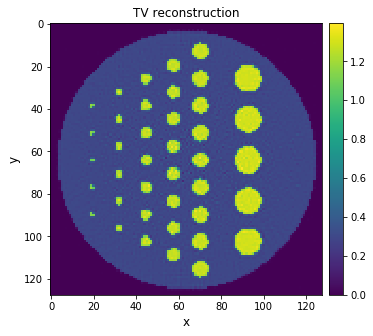

In [22]:
# Define Gradient Operator and BlockOperator 
Grad = Gradient(ig)
K = BlockOperator(Grad, A)

# Define BlockFunction F using the MixedL21Norm() and the L2NormSquared()
alpha = 2
f1 = alpha * MixedL21Norm()
f2 = L2NormSquared(sino_num)
F = BlockFunction(f1, f2)

# Define BlockFunction G, as a positivity constraint
G = IndicatorBox(lower=0)

# Compute operator norm and choose step-size sigma and tau such that sigma*tau||K||^{2}<1
normK = K.norm()
sigma = 1
tau = 1/(sigma * normK**2)

pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, 
            max_iteration = 200, update_objective_interval = 100)
pdhg.run(verbose = True)

pdhg_recon = pdhg.get_output()
show(pdhg_recon, title = 'TV reconstruction')

### FBP and SIRT reconstructions

Let's now try: 

1. A filtered back projection reconstruction, using a _Ram-Lak_ filter.
1. A Simultaneous Iterative Reconstruction Technique (SIRT):
    
    __(Reminder)__ : If A u = g, then SIRT algorithm:  $$u^{k+1} = \mathcal{P}_{C}(u^{k} + D A^{T} M ( g - A u^{k}))$$ where,
    
    $$
    \begin{cases}
    M = \frac{\mathbb{1}}{A\mathbb{1}}, \quad m_{ii} = \frac{1}{\sum_{j} a_{ij}}, \quad\mbox{ sum over columns }\\
    D = \frac{\mathbb{1}}{A^{T}\mathbb{1}}, \quad d_{jj} = \frac{1}{\sum_{i} a_{ij}}\quad\mbox{ sum over rows }\\
    \end{cases}
    $$
    
and $\mathcal{P}_{C}$ is a projection onto a convex set C. For this demo, we will use a positivity constraint.   
    
Recall,

` fbp = FBP(ig, ag, filter_type = 'ram-lak') `

` fbp.set_input(sino_num)`

` fbp_recon = fbp.get_output()` 

and for SIRT

` x_init = ig.allocate()` 

` sirt = SIRT(x_init = x_init, operator = A, data=sino_num, constraint = IndicatorBox(lower=0),max_iteration = 50)`

` sirt.run(verbose=False) `

` sirt_recon = sirt.get_output() `

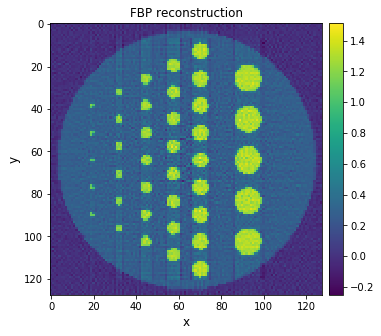

In [23]:
# FBP reconstruction
fbp = FBP(ig, ag, filter_type = 'ram-lak')
fbp.set_input(sino_num)
fbp_recon = fbp.get_output()
show(fbp_recon, title = 'FBP reconstruction')

SIRT setting up
SIRT configured


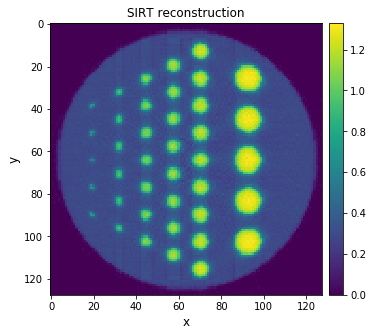

In [25]:
# Run SIRT algoritm, with positivity constraint

# Setup and run the SIRT algorithm  
x_init = ig.allocate()  

sirt = SIRT(x_init = x_init, operator = A, data=sino_num, constraint = IndicatorBox(lower=0),
           max_iteration = 50)
sirt.run(verbose=False)

sirt_recon = sirt.get_output()
show(sirt_recon, title = 'SIRT reconstruction')

In [26]:
from utilities import islicer
stack_recon = ImageData(np.array([cgls_recon.as_array(), 
                                  fbp_recon.as_array(), 
                                  sirt_recon.as_array(), 
                                  pdhg_recon.as_array()]))

islicer(stack_recon, 0)

interactive(children=(IntSlider(value=0, continuous_update=False, description='x', max=3), Output()), _dom_cla…

IntSlider(value=0, continuous_update=False, description='x', max=3)

## Exercise 2 :

For this exercise, we load a 3D Tomophantom and perform the following reconstuctions

1. FBP.
1. SIRT.
1. PDHG with no regulariser.
1. PDHG with [Tikhonon regulisation](#Tikhonov) with $L = \nabla$. 
1. PDHG with Total variation regulasiation.

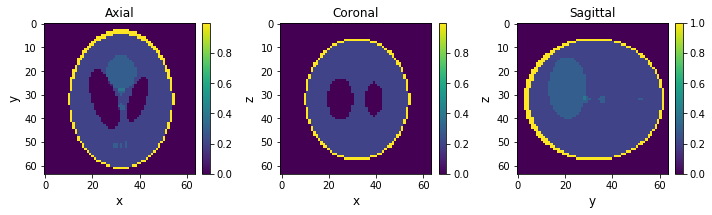

interactive(children=(IntSlider(value=32, continuous_update=False, description='x', max=63), Output()), _dom_c…

IntSlider(value=32, continuous_update=False, description='x', max=63)

In [27]:
# Load 3D Shepp-Logan phantom from TomoPhantom

model = 13 # select a model number from the library
N = 64 # Define phantom dimensions using a scalar value (cubic phantom)
path = os.path.dirname(tomophantom.__file__)
path_library3D = os.path.join(path, "Phantom3DLibrary.dat")
#This will generate a N_size x N_size x N_size phantom (3D)
phantom_tm = ImageData(TomoP3D.Model(model, N, path_library3D))

# Define image geometry.
ig = ImageGeometry(voxel_num_x = N, voxel_num_y=N, voxel_num_z=N)
im_data = ig.allocate()
im_data.fill(phantom_tm)

# Show data in Axial, Coronal and Sagittal view
show(im_data)

# Use islicer 
islicer(im_data, 2, slice_number = 32)

In [ ]:
angles = np.linspace(0, np.pi, 180, dtype='float32')
ag = AcquisitionGeometry('parallel',
                         '3D',
                         angles,
                         pixel_num_h = N,
                         pixel_num_v = N)

A = AstraProjector3DSimple(ig, ag)
sino_num = A.direct(im_data)

# show sino add title
islicer(sino_num, 2, slice_number = 32)
# show(sino_num, title = 'Acquisition Data')

In [ ]:
# Run FBP reconstruction 

fbp3D = FBP(ig, ag, 'ram-lak')
fbp3D.set_input(sino_num)
fbp3D_recon = fbp3D.get_output()

# Run SIRT reconstruction 

x_init = ig.allocate()  
sirt3D = SIRT(x_init = x_init, operator = A, data=sino_num, constraint = IndicatorBox(lower=0),
           max_iteration = 50)
sirt3D.run(verbose=False)
sirt3D_recon = sirt3D.get_output()

## End of DEMO

In [ ]:
# Define F
F = 0.5 * L2NormSquared(sino_num)

If we compare the denoising problem from the previous demo, then the last minimisation problem is a _Total variation_ denoising problem with  _noisy data_ $g:= (x^{n} - \tau K^{*} \overline{x}^{n})$ and a regularising parameter $\alpha = \tau$.

In order to solve this minimisation problem, we use the [CCPi-Regularisation-Toolkit](https://github.com/vais-ral/CCPi-Regularisation-Toolkit) and the Fast Gradient Projection algorithm with a Total variation (__FGP_TV__) regulariser. For more details, see []. The advantage of __CCPI-Regularisation-Toolkit__ is that we can solve the above subproblem very-fast since we can choose a CPU/GPU. 


Now, we need to define the function G. However, this type is not an actual function but rather a denoising minimisation problem with a TV regulariser. Hence, if call __FGP_TV__, we need to specify the following arguments in order:

1. Regularising parameter
1. Iterations for the TV denoising minimisation problem
1. Tolerance
1. Isotropic or Anisotropic definition of TV: Isotropic(0), Anisotropic(1)
1. Positivity Constraint: No (0), Yes(1)
1. Printing
1. Device: 'cpu','gpu'

In [ ]:
reg_parameter = 200
iterations = 50
tolerance = 1e-6
methodTV = 0
pos_cons = 1
printing = 0
device = 'gpu'

G = FGP_TV(reg_parameter, iterations, tolerance, methodTV, pos_cons, printing, device)

K = A

normK = K.norm()
sigma = 1
tau = 1/(sigma * normK**2)

# Setup and run the PDHG algorithm
pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, 
            max_iteration = 200)
pdhg.run(verbose=False)
pdhg_recon = pdhg.get_output()
show(pdhg_recon, title = 'PDHG reconstruction')

# Exercise 1: 3D TV reconstruction

In this exercise, we will solve a TV reconstruction problem using the two methods described above. We will load a 3D tomophantom from the [list](https://github.com/dkazanc/TomoPhantom/blob/master/PhantomLibrary/models/Phantom3DLibrary.dat). For example, we select _model=12_ for a 3D Shepp-Logan phantom. 

In [ ]:
model = 13 # select a model number from the library
N = 64 # Define phantom dimensions using a scalar value (cubic phantom)
path = os.path.dirname(tomophantom.__file__)
path_library3D = os.path.join(path, "Phantom3DLibrary.dat")
#This will generate a N_size x N_size x N_size phantom (3D)
phantom_tm = ImageData(TomoP3D.Model(model, N, path_library3D))

# Define image geometry.
ig = ImageGeometry(voxel_num_x = N, voxel_num_y=N, voxel_num_z=N)
im_data = ig.allocate()
im_data.fill(phantom_tm)

# Show data in Axial, Coronal and Sagittal view
show(im_data)

# Use islicer 
islicer(im_data, 2, slice_number = 32) # value=32)

Then, we define our AcqusitionGeometry, AstraProjector and our AcquisitionData for the 3D case.

In [ ]:
angles = np.linspace(0, np.pi, 180, dtype='float32')
ag = AcquisitionGeometry('parallel',
                         '3D',
                         angles,
                         pixel_num_h = N,
                         pixel_num_v = N)

A = AstraProjector3DSimple(ig, ag)
sino_num = A.direct(im_data)

# show sino add title
show(sino_num, title = 'Acquisition Data')

## Part (a)

For the first part, we would like to reconstruct using:

1. FBP with a 'ram-lak' filter.
1. SIRT with a positivity constraint.
1. CGLS.

In [ ]:
# Run FBP reconstruction 

### START CODE HERE (3 lines) ### 
    
    # fbp3D = ... 
    # fbp3D = ... 
    # fbp3D = ... 
    
### END CODE HERE ###


# Run SIRT reconstruction 

### START CODE HERE (4 lines) ### 
    
    # x_init = 
    # sirt3D = ... 
    # sirt3D = ... 
    # sirt3D = ... 
    
### END CODE HERE ###


# Run CGLS reconstruction 

### START CODE HERE (4 lines) ### 
    
    # x_init = 
    # cgls3D = ... 
    # cgls3D = ... 
    # cgls3D = ... 
    
### END CODE HERE ###


# SHOW RECONCTRUCTIONS

In [ ]:
# Run FBP reconstruction 
fbp3D = FBP(ig, ag, 'ram-lak')
fbp3D.set_input(sino_num)
fbp3D_recon = fbp3D.get_output()

# Run SIRT reconstruction 
x_init = ig.allocate()  
sirt3D = SIRT(x_init = x_init, operator = A, data=sino_num, constraint = IndicatorBox(lower=0),
           max_iteration = 50)
sirt3D.run(verbose=False)
sirt3D_recon = sirt3D.get_output()

# Run CGLS reconstruction 
cgls3D = CGLS(x_init = x_init, operator = A, data = sino_num, max_iteration = 10)
cgls3D.run(verbose = False)
cgls3D_recon = cgls3D.get_output()

In [ ]:
show(fbp3D_recon, title = 'FBP reconstruction', figure_size = (15,6))
show(sirt3D_recon, title = 'SIRT reconstruction',  figure_size = (15,6))
show(cgls3D_recon, title = 'CGLS reconstruction', figure_size = (15,6))

## Part (b)

For the second part, we would like to reconstruct using the Total variation regulariser and the two method of PDHG:

### PDHG split

1. Define a BlockOperator K with the Gradient and Projection operators.
1. Define a BlockFunction F with the MixedL21Norm() and the L2NormSquared(sino_num).
1. Define a function G for the positivity constraint IndicatorBox(lower=0).
1. Compute operator norm of K and define sigma,tau step-sizes such that sigma*tau||K||^{2}<1.
1. Setup and run PDHG.

### PDHG explicit

1. Define an operator K as the Projection operator A.
1. Define a function F as the L2NormSquared(sino_num).
1. Define a _function_ G, which solves a Total variation denosing problem using the _Fast Gradient Projection_ algoritm, i.e.,
    
    __G = FGP_TV(reg_parameter, iterations, tolerance, methodTV, pos_cons, printing, device)__. 
    
    Do not forget to enforce the positivity constraint.
    
1. Compute operator norm of K and define sigma,tau step-sizes such that $\sigma\tau\|K\|^{2}<1$.
1. Setup and run PDHG


In [ ]:
# Part (b)

    ############
    # PDHG split
    ############
    
    ### START CODE HERE (2 lines) ### 

        # Grad =     
        # K = 

    ### END CODE HERE ###
    
    ### START CODE HERE (3 lines) ### 

        # f1 =
        # f2 = 
        # F = 

    ### END CODE HERE ### 
    
    ### START CODE HERE (1 line) ### 

        # G = 

    ### END CODE HERE ###     
    
    ### START CODE HERE (3 lines) ### 

        # normK =
        # sigma = 
        # tau = 

    ### END CODE HERE ### 
    
    ### START CODE HERE (2 lines) ### 

        # pdhg = ...
        # pdhg ...

    ### END CODE HERE ### 
    
    # SHOW RECONSTRUCTION

    #####################################

    ###############
    # PDHG explicit
    ###############
    
    ### START CODE HERE (1 line) ### 

        # K =      

    ### END CODE HERE ###
    
    ### START CODE HERE (1 line) ### 

        # F =      

    ### END CODE HERE ###
    
    ### START CODE HERE (1 line) ### 

        # G =      

    ### END CODE HERE ###
    
    ### START CODE HERE (3 lines) ### 

        # normK =
        # sigma = 
        # tau = 

    ### END CODE HERE ### 
    
    ### START CODE HERE (2 lines) ### 

        # pdhg = ...
        # pdhg ...

    ### END CODE HERE ### 
    
    # SHOW RECONSTRUCTION

In [ ]:
Grad = Gradient(ig)
K = BlockOperator(Grad, A)

alpha = 10
f1 = alpha * MixedL21Norm()
f2 = 0.5 * L2NormSquared(sino_num)
F = BlockFunction(f1, f2)

G = IndicatorBox(lower=0)

normK = K.norm()
sigma = 1
tau = 1/(sigma*normK**2)

pdhg3D = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, max_iteration = 200)
pdhg3D.run(verbose=False)
pdhg3D_split = pdhg3D.get_output()

In [ ]:
K = A
F = f2
G = FGP_TV(alpha, 50, 1e-6, 0, 1, 0, 'gpu')

normK = K.norm()
sigma = 1
tau = 1/(sigma*normK**2)

pdhg3D = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, max_iteration = 200)
pdhg3D.run(verbose=False)
pdhg3D_explicit = pdhg3D.get_output()
show(pdhg3D_explicit)

In [ ]:
islicer(fbp3D_recon, 0, title = 'FBP', slice_number = 32)
islicer(sirt3D_recon, 0, title = 'SIRT', slice_number = 32)
islicer(cgls3D_recon, 0, title = 'CGLS', slice_number = 32)
islicer(pdhg3D_split, 0, title = 'PDHG with BlockFramework', slice_number = 32)
islicer(pdhg3D_explicit, 0, title = 'PDHG without BlockFramwork', slice_number = 32)

<h1><center>End of Part II </center></h1>

<a id='Appendix'></a>
# Appendix

1. The PDHG algorithm is described below :
    
<center> Choose step-sizes $\tau$, $\sigma$, such that $\tau\sigma\|K\|^{2}<1$ </center> 
<center> Choose $\theta\in[0,1]$ </center>
<center> Let $(x^{0}, y^{0})\in X\times Y$ and $\overline{x}^{0} = x^{0}$ </center>
<br>
\begin{align}
    y^{n+1}  & = \mathrm{prox}_{\sigma\mathcal{F}^{*}}( y^{n} + \sigma K \overline{x}^{n} )\quad \mbox{ (Dual Problem)}\tag{1}\\[10pt]
    x^{n+1}  & = \mathrm{prox}_{\tau\mathcal{G}^{*}} ( x^{n} - \tau K^{*} \overline{x}^{n} )\quad \mbox{ (Primal Problem) }\tag{2}\\[10pt]
    \overline{x}^{n+1} & = x^{n+1} + \theta ( x^{n+1} - x^{n} )\quad\mbox{ (Over-relaxation step) }
\end{align}
    
__**REMINDER**__: Let $\lambda>0$ and $f$ a convex function. Then

$$
z : = \mbox{prox}_{\lambda f}(x) = \underset{z}{\operatorname{argmin}} \frac{1}{2}\|z - x \|^{2} + \lambda f(z) \quad (\mbox{Proximal Operator})
$$
 
__**Note**__: We assume that proximal operators have a closed form solution or can be solved efficiently using an iterative algorithm.

If we go back to the PDHG algorithm:


<center> Choose step-sizes $\tau$, $\sigma$, such that $\tau\sigma\|K\|^{2}<1$ </center> 
<center> Choose $\theta\in[0,1]$ </center>
<center> Let $(x^{0}, y^{0})\in X\times Y$ and $\overline{x}^{0} = x^{0}$ </center>
<br>
$$
\begin{align}
    y^{n+1}  & = ( I + \sigma \partial F^{*} ) ^ {-1} ( y^{n} + \sigma K \overline{x}^{n} )\quad \mbox{ (Dual Problem)}\tag{1}\\[10pt]
    x^{n+1}  & = ( I + \tau \partial G ) ^ {-1} ( x^{n} - \tau K^{*} \overline{x}^{n} )\quad \mbox{ (Primal Problem) }\tag{2}\\[10pt]
    \overline{x}^{n+1} & = x^{n+1} + \theta ( x^{n+1} - x^{n} )\quad\mbox{Over-relaxation step}
\end{align}$$

then the __first (dual) subproblem__ has a closed form solution:
    
$$
\begin{align}
    y^{n+1}  & = ( I + \sigma \partial F^{*} ) ^ {-1} ( y^{n} + \sigma K \overline{x}^{n} ) \Longleftrightarrow \\
    y^{n+1}  & = \mathrm{prox}_{\sigma F^{*}}( y^{n} + \sigma K \overline{x}^{n}) \Longleftrightarrow 
    \underset{y}{\operatorname{argmin}} \frac{1}{2}\| y - (y^{n} + \sigma K \overline{x}^{n})\|^{2} + \sigma F^{*}(y). \end{align}
$$

However, with the above setting for function G, the __second (primal) problem__ has not a closed-form solution and need to use an iterative algorithm in order to compute it:

$$
\begin{align}
x^{n+1}  & = ( I + \tau \partial G ) ^ {-1} ( x^{n} - \tau K^{*} \overline{x}^{n} )\quad \Longleftrightarrow \\
x^{n+1}  & = \mathrm{prox}_{\tau G}(x^{n} - \tau K^{*} \overline{x}^{n})\Longleftrightarrow \\
\underset{x}{\operatorname{argmin}} & \frac{1}{2} \| x - (x^{n} - \tau K^{*} \overline{x}^{n}) \|^{2} + \tau G(x)\Longleftrightarrow \\
\underset{x}{\operatorname{argmin}} & \frac{1}{2} \| x - (x^{n} - \tau K^{*} \overline{x}^{n}) \|^{2} + \tau \| \nabla x\|_{2,1}
\end{align}
$$

If we compare the denoising problem from the previous demo, then the last minimisation problem is a _Total variation_ denoising problem with  _noisy data_ $g:= (x^{n} - \tau K^{*} \overline{x}^{n})$ and a regularising parameter $\alpha = \tau$.

In order to solve this minimisation problem, we use the [CCPi-Regularisation-Toolkit](https://github.com/vais-ral/CCPi-Regularisation-Toolkit) and the Fast Gradient Projection algorithm with a Total variation (__FGP_TV__) regulariser. For more details, see []. The advantage of __CCPI-Regularisation-Toolkit__ is that we can solve the above subproblem very-fast since we can choose a CPU/GPU. 